 ![logo][gfzlogo]
 
 #   ENHANS -   Exposure modelling Workshop   -  May 2017
 
 ---
 
 
 ## 5.1 - Building Typology Assignment
 
 
 ---

 


[gfzlogo]:gfz_logo2.jpg

## language: Python 2.7

### first: Load packages

In [1]:
import sys
import os
import pandas as pd
import numpy as np
from string import Template
import matplotlib.pyplot as plt
%matplotlib inline
#from lxml import etree
from sqlalchemy import create_engine
from sqlalchemy.sql import text

#used by the nrml 
NAMESPACE = 'http://openquake.org/xmlns/nrml/0.5'
GML_NAMESPACE = 'http://www.opengis.net/gml'
SERIALIZE_NS_MAP = {None: NAMESPACE, 'gml': GML_NAMESPACE}


# Query of building data from the database

the data is fetched from the database (either local or from remote) using a SQL query. 

In our case we retrieve the following information:

- latitude (of the centroid of the building)
- longitude (of the centroid of the building)
- ID of the building (same as used in the RRVS interface)
- mat_type: material type
- mat_tech: material technology
- mat_prop: material properties
- llrs: lateral load resisting system
- llrs_duct: ductility of the lateral load resisting system
- height: height, typology of observation
- height_1: height, value
- height_2: height, optional second value (for intervals)
- yr_built: year of construction
- occupy: type of occupancy
- occupy_dt: detail on the occupancy
- str_irreg: structural irregularities
- str_irreg_dt: detail on the structural irregularities
- str_irreg_type: type of structural irregularities
- roof_shape: shape of the roof
- roofcovmat: material of the roof cover
- roofsysmat: material of the roof structural system 
- roofsystyp: type of roof structural system
- roof_conn: type of roof connection
- floor_mat: material of the floors
- floor_type: type of the floors
- floor_conn: type of floors connection 

##Exercise 1
Query different attribute types from the database

##Exercise 2
Include a spatial query. Are boundary data defined ?

In [7]:
engine = create_engine('postgresql://postgres@localhost:5432/rem')

## Query data, option 1: use the integrated view

In [152]:
# query to the database
t=pd.read_sql_query("""
select 
st_x(st_transform(st_centroid(v.the_geom),4326)) lon,
st_y(st_transform(st_centroid(v.the_geom),4326)) lat,
v.object_id,
v.mat_type,
v.mat_tech,
v.mat_prop,
v.llrs,
v.llrs_duct,
v.height,
v.height_1,
v.height_2,
v.yr_built,
v.occupy,
v.occupy_dt,
v.str_irreg,
v.str_irreg_dt,
v.str_irreg_type,
v.roof_shape,
v.roofcovmat,
v.roofsysmat,
v.roofsystyp,
v.roof_conn,
v.floor_mat,
v.floor_type,
v.floor_conn
from asset.ve_object v;""",con=engine)

#test
t.head()

,lon,lat,object_id,mat_type,mat_tech,mat_prop,llrs,llrs_duct,height,height_1,...,str_irreg_dt,str_irreg_type,roof_shape,roofcovmat,roofsysmat,roofsystyp,roof_conn,floor_mat,floor_type,floor_conn
0,29.028130,41.091018,2001,MAT99,MATT99,SPO,L99,DU99,H,222,...,IRP99,IRT99,R99,RMT99,RSM99,RST99,RCN99,F99,FT99,FWC99
1,29.017130,41.076783,2002,MAT99,MATT99,MATP99,L99,DU99,H,2,...,IRP99,IRT99,R99,RMT99,RSM99,RST99,RCN99,F99,FT99,FWC99
2,29.017703,41.076670,2003,MAT99,MATT99,MATP99,L99,DU99,H,2,...,IRP99,IRT99,R99,RMT99,RSM99,RST99,RCN99,F99,FT99,FWC99
3,29.018097,41.076802,2004,MAT99,MATT99,MATP99,L99,DU99,H,3,...,IRP99,IRT99,R99,RMT99,RSM99,RST99,RCN99,F99,FT99,FWC99
4,29.018571,41.078986,2005,MAT99,MATT99,MATP99,L99,DU99,H,3,...,IRP99,IRT99,R99,RMT99,RSM99,RST99,RCN99,F99,FT99,FWC99


## Query data, option 2: use a 'crosstab'

In [13]:
# query to the database
def get_exp_raw(engine,survey,status):
    
    sql = """
select ct.*, oa.attribute_numeric_1 height_1  from crosstab(
   'select oa.object_id, oa.attribute_type_code, oa.attribute_value
    from asset.object_attribute as oa  order by 1,2;') 
    as ct(object_id integer,build_subtype varchar,
build_tpye varchar,
comment varchar,
floor_conn varchar,
floor_mat varchar,
floor_type varchar,
foundn_sys varchar,
height varchar,
height2 varchar,
llrs varchar,
llrs_duct varchar,
mat_prop varchar,
mat_tech varchar,
mat_type varchar,
nonstrcexw varchar,
occupy varchar,
occupy_dt varchar,
plan_shape varchar,
position varchar,
roof_conn varchar,
roof_covmat varchar,
rooof_shape varchar,
roof_sysmat varchar,
roofsystyp varchar,
rrvs_status varchar,
str_irreg varchar,
str_irreg_2 varchar,
str_irreg_dt varchar,
str_irreg_dt_2 varchar,
str_irreg_type varchar,
str_irreg_type_2 varchar,
vuln varchar,
yr_built varchar
), asset.object_attribute oa, asset.object o 
where oa.object_id = ct.object_id and oa.attribute_type_code='HEIGHT' 
and ct.rrvs_status='{}' and o.gid = ct.object_id and o.survey_gid={};
  """.format(status,survey)

    t=pd.read_sql_query(sql,con=engine)
    return t

#test
tt = get_exp_raw(engine, 7,'COMPLETED')

#Structural features defining the building types

We specify which structural features are considered in order to assign a building type, and which weight has the particular attribute type within the assignment process.

We do it using a python "dictionary" {key:value} construct, where the keys are the considered attributes and the values are the related weights. 

If these features provide an exhaustive description, the sum should sum up to one.

In [9]:
#define the weight of attributes as a dictionary
wgs = {
    'mat_type':0.25,
    'mat_tech':0.2,
    'mat_prop':0.05,
    'llrs':0.15,
    'llrs_duct':0.05,
    'floor_mat':0.1
    }

#are they exhaustive? if so, they should sum up to 1
sum(wgs.values())

0.8

#Definition of the building typologies

Each building typology is defined by listing, for each attribute type considered (see above), a set of compatibile attribute values, each with a specific 'score'  $s$.





In [10]:
# define the building types
# define the weight of values for each attribute and each building type

bmod={}
#TYPE 1: MUR+CLBRS+MOC/LWAL+DNO/FW/H_BET:1:3
bmod['MUR1']={}
bmod['MUR1']['mat_type']= {'MUR':1,'M99':0.8,'MAT99':0}
bmod['MUR1']['mat_tech']={'CLBRS':1,'CLBRH':1,'MATT99':0}
bmod['MUR1']['mat_prop']={'MOC':1,'MATP99':0}
bmod['MUR1']['llrs']={'LWAL':1,'L99':0}
bmod['MUR1']['llrs_duct']={'DNO':1,'DU99':0}
bmod['MUR1']['floor_mat']={'FW':1,'F99':0}
bmod['MUR1']['height_1']={'H_MIN':1,'H_MAX':3}

#TYPE 2: CR+PC+MOC/LFLS+DUC/FC/H_BET:5:9
bmod['RC1']={}
bmod['RC1']['mat_type']= {'CR':1,'C99':0.5,'MAT99':0}
bmod['RC1']['mat_tech']={'PC':1,'MATT99':0}
bmod['RC1']['mat_prop']={'MOC':1,'MATP99':0}
bmod['RC1']['llrs']={'LFLS':1,'L99':0}
bmod['RC1']['llrs_duct']={'DUC':1,'DU99':0}
bmod['RC1']['floor_mat']={'FC':1,'F99':0}
bmod['RC1']['height_1']={'H_MIN':5,'H_MAX':9}

#TYPE 3: W+WO+SPBA///H_BET:1:5
bmod['WOOD1']={}
bmod['WOOD1']['mat_type']= {'W':1,'MAT99':0}
bmod['WOOD1']['mat_tech']={'WO':1,'MATT99':0}
bmod['WOOD1']['mat_prop']={'SPBA':1,'MATP99':0}
bmod['WOOD1']['llrs']={'L99':0}
bmod['WOOD1']['llrs_duct']={'DU99':0}
bmod['WOOD1']['floor_mat']={'F99':0}
bmod['WOOD1']['height_1']={'H_MIN':1,'H_MAX':5}

#TYPE 4: W+WBB+SPBA///H_BET:1:5
bmod['WOOD2']={}
bmod['WOOD2']['mat_type']= {'W':1,'MAT99':0}
bmod['WOOD2']['mat_tech']={'WBB':1,'MATT99':0}
bmod['WOOD2']['mat_prop']={'MATP99':0}
bmod['WOOD2']['llrs']={'L99':0}
bmod['WOOD2']['llrs_duct']={'DU99':0}
bmod['WOOD2']['floor_mat']={'F99':0}
bmod['WOOD2']['height_1']={'H_MIN':1,'H_MAX':5}


#Computing the building scores

* * *

For each building is then assigned a score $S$ defined as:

$$ S(b) = \sum_i w_i ( \sum_k \delta_{ik}(b) s_k) $$

where

$$   
\delta_{ik}(b) =\left\{
  \begin{array}{@{}ll@{}}
    1, & \text{if}\ v_k \in B(b) \\
    0, & \text{otherwise}
  \end{array}\right.
$$

The score $S$ is then subject to constraints $C$

$$ S(b) = S(b) \prod_i \delta_{i}(b)$$

where

$$   
\delta_{i}(b) =\left\{
  \begin{array}{@{}ll@{}}
    1, & \text{if}\ C_i \ \text{is satisfied}\ \\
    0, & \text{otherwise}
  \end{array}\right.
$$

---

In this case, a single constraint can be defined for the height. 

In case the constrain is considered too a strong filtering, it can be considered as an additional weighted component (see calculation below)

In [11]:
# function that computes the score of a building for a building type
def compute_single_bscore(bdg,btype):
    #compute the score
    a=[bmod[btype][k].get(bdg[k],-1) for k in wgs.keys()]
    s1 = np.dot(a,wgs.values())
    #check the additional attribute, in this case the height
    ch1 = ((bdg['height_1'] >= bmod[btype]['height_1']['H_MIN']) & (bdg['height_1'] <= bmod[btype]['height_1']['H_MAX']))
    
    #apply the constrain
    #s = s1*ch1
    #alternative: use the constrain with a weight
    s = s1+ch1*(1-sum(wgs.values()))

    
    return s

# compute the score of a building for all defined building types
def compute_bscore(bdg):
    #res = pd.DataFrame(columns=bmod.keys())
    res={}
    for bt in bmod.keys():
        res[bt]=compute_single_bscore(bdg,bt) 
        res['object_id']=bdg['object_id']
        
    return res

#Building type assignment

once the scores are computed for each building, we can assign the building type with the highest score.

##Caution
if the scores are all equal, or very low, the assignment may be misleading. Its therefore better to set a threshold for the score (e.g. $S\ge 0$), or a more sophisticaed solution.



In [14]:
#test
bdgs = tt[tt['mat_type']!='MAT99']

scores = pd.DataFrame([compute_bscore(b) for i,b in bdgs.iterrows()])

# assign to each building the argmax of the score
scores['btype']=scores[bmod.keys()].idxmax(1)

# set a flag to 'true' for the buildings whose best score is >=0
scores['valid']=scores.apply(lambda df:df[df['btype']]>0, 1)

#select only the valid ones
scores[scores['valid']]


,MUR1,RC1,WOOD1,WOOD2,object_id,btype,valid
1,0.05,-0.45,-0.55,-0.55,21123,MUR1,True
3,0.15,-0.75,-0.55,-0.55,21193,MUR1,True
8,0.35,-0.55,-0.55,-0.55,21302,MUR1,True
10,0.15,-0.75,-0.55,-0.55,21335,MUR1,True
11,0.35,-0.55,-0.55,-0.55,21382,MUR1,True
12,0.15,-0.75,-0.55,-0.55,21437,MUR1,True
14,0.55,-0.75,-0.55,-0.55,21463,MUR1,True
15,0.40,-0.60,-0.60,-0.60,21473,MUR1,True
17,-0.50,-0.80,0.30,-0.10,21490,WOOD1,True
18,0.05,-0.65,-0.45,-0.45,21528,MUR1,True


## Now we can merge the building assignment with the original data

Only the data considered valid are taken into account

In [19]:
expo_df = pd.merge(tt[['object_id','mat_type','mat_tech','mat_prop']],
         scores[scores['valid']][['object_id','btype']], how='inner', on='object_id')

expo_df

,object_id,mat_type,mat_tech,mat_prop,btype
0,21123,MUR,ST99,MOC,MUR1
1,21193,MUR,MUN99,MO99,MUR1
2,21302,MUR,CLBRS,MO99,MUR1
3,21335,MUR,MO,MO99,MUR1
4,21382,MUR,CLBRS,MO99,MUR1
5,21437,MUR,MUN99,MO99,MUR1
6,21463,MUR,CLBRS,MO99,MUR1
7,21473,MUR,CLBRH,MOCL,MUR1
8,21490,W,WO,MON,WOOD1
9,21528,MUR,MO,MO99,MUR1


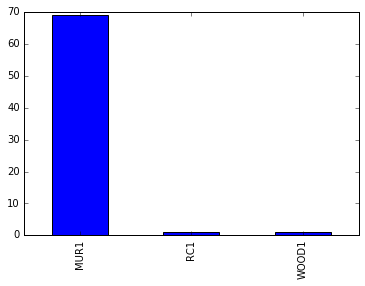

In [24]:
expo_df['btype'].value_counts().plot(kind='bar')

## ... and write back the processed data into the database

In [25]:
#sql query to join the processed table with the information in the rrvs database
sqltempquery = Template('drop table if exists $tablename;\
create table $tablename as \
select v.*, p.btype \
from asset.ve_object v inner join $tablename_tmp p \
on v.object_id = p.object_id;\
drop table if exists $tablename_tmp;')

# function to export the processed building information to the database
def export_database(df, tablename):
    sql_pars=dict(tablename ='{}'.format(tablename),
                  tablename_tmp = '{}_tmp'.format(tablename))
    engine.execute(text("drop table if exists {};".format(sql_pars['tablename_tmp'])))
    df.to_sql(sql_pars['tablename_tmp'],engine)
    t = sqltempquery.substitute(sql_pars)
    engine.execute(text(t))

# create the processed table in the public schema of the database
export_database(expo_df,'proc_expo')

##Exercise
The resulting model can now be queried from the database and mapped using QGIS. Try this out!

